# Data Science Course Final Project: *Predicting Song Streaming Patterns*

## 1. Problem Statement
For my final project, I would like to build a model that can **predict the poularity of a given song (measured by # of streams per day) by key features of the song** The music industry is worth an estimated 26 billion dollars but it can be difficult to break into. Currently 78% of people use some form of music streaming service and streaming services make up 84% of the US music industry's revenue. Artists are paid a fraction of a penny per stream. ($0.003-0.005), so it's important to maximize the number of times their music is streamed.

*How the Model Can Inform Decision Making*

Using data from the most streamed songs on Spotify, I want to build a model that can predict how many streams per day a song will have using some of the Spotify data as the primary features informing the model. Using this model, recording artists and record labels could figure out which attributes to include in a song to potentially make it more popular and therefore streamed more. 

## 2. Approach Overview

### 2.1 Data Source
The spotify api allows users to look up statistics on songs that are not necessarily available as front-end data to everyday users. A user on __[kaggle](https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023/)__ was able to compile the top 952 songs streamed on Spotify as of August 2023.

For this project,  _streams/day_ is calculated as **total number of streams**/**days since the song was released**. For songs that were released before the launch of spotify, _streams/day_ is calculated as **total number of streams**/**days since spotify launched**.

### 2.2 Target Variables
Initially, I planned to use total number of streams as the target variable but realized that doesn't present a truely accurate picture of a song's popularity. If two songs had the same number of streams but one was released 2 years ago and the other two months ago, it's safe to argue that the song released 2 months ago is more popular. Since `streams_per_day` has a strong skew, the target variable is `log_streams_per_day` which is a log-transformation of the `streams_per_day` variable.

### 2.3 Feature Variables
The dataset includes over 20 feature columns but several of those features are only available _after_ a song has been released so are therefore not helpful in informing the _creation_ of a song. Several of the feature columns have a strong skew so I have included a log transformation of those variables to help with the prediction. Some of the key features I'm using for my model include:

    - Beats per minute (bpm)
    - The month the song was released (released_month)
    - Whether the mode of the song is Major or Minor (mode_Minor)
    - Percentage indicating how suitable the song is for dancing (danceability_%)
    - Percentage indicating the positivity of the song's musical content (valence_%)
    - Percentage indicating the perceived energy level of the song (energy_%)

### 2.4 Model Approach
The problem described above is a regression problem. I am attempting to predict the average number of streams a given song will have in a day. I tested three different regression models for this problem. The first was a simple Linear Regression model, the second a Decision Tree Model, and the third a Random Forest Model. I will use Mean Absolute Error as the primary metric to evaluate each model. Upon finding the best basic model I will then attempt to improve upon the model using GridSearchCV and KFold

# 3. Data Preparation

In [1]:
#Notebook preparation
import pandas as pd
import numpy as np

#Import visualization libraries 
import matplotlib.pyplot as plt
import seaborn as sns

#Import libraries required for modeling
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from model_inspector import get_inspector
from sklearn.dummy import DummyRegressor

In [2]:
songs = pd.read_csv('../assets/data/spotify2023_final.csv')

In [3]:
# Creating the streams_per_day variable conditionally to account for songs older than Spotify
songs['streams_per_day'] = np.where(songs.days_since_launch < songs.days_since_release, 
                                    songs.streams/songs.days_since_launch, 
                                    songs.streams/songs.days_since_release)

In [4]:
# There are several variables in the dataset that are only available after the song has been released 
# and several that add noise and no signal
songs.drop(columns=['released_year',
                    'released_day',
                    'in_spotify_playlists',
                    'in_spotify_charts',
                    'in_apple_playlists',
                    'in_apple_charts',
                    'in_deezer_playlists',
                    'in_deezer_charts',
                    'in_shazam_charts',
                    'date_data_collected',
                    'track_name',
                    'artist(s)_name',
                    'released_date',
                    'days_since_release',
                    'streams',
                    'date_spotify_launched',
                    'days_since_launch',
                    'key'
                    ], inplace=True)

## 3.1 Testing for and Handling Missing Values

In [5]:
# There are no missing values
songs.isna().sum()

artist_count          0
released_month        0
bpm                   0
mode                  0
danceability_%        0
valence_%             0
energy_%              0
acousticness_%        0
instrumentalness_%    0
liveness_%            0
speechiness_%         0
streams_per_day       0
dtype: int64

### 3.2 Cleaning Feature Variables & Target Variable

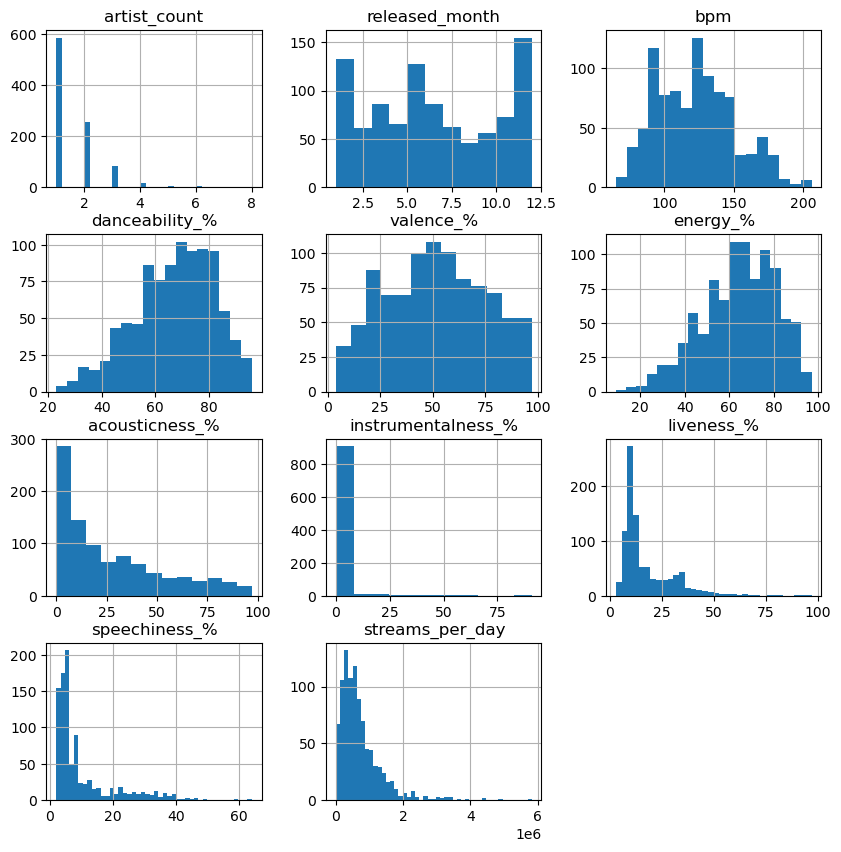

In [6]:
# Looking for skew
songs.hist(figsize=(10,10), bins='auto');

In [7]:
# Creating log-transformations of skewed variables
songs['log_liveness_%'] = np.log(songs['liveness_%'])
songs['log_speechiness_%'] = np.log(songs['speechiness_%'])
songs['log_streams_per_day'] = np.log(songs.streams_per_day)

# Turning mode into a boolean
songs = pd.get_dummies(songs, drop_first=True)

# Dropping the non-log transformed streams per day
songs = songs.drop(columns='streams_per_day')

### 3.4 Summary of Final Clean Dataset

In [8]:
# Final shape of dataset
songs.shape

(952, 14)

In [9]:
# Columns in the dataset
songs.columns

Index(['artist_count', 'released_month', 'bpm', 'danceability_%', 'valence_%',
       'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%',
       'speechiness_%', 'log_liveness_%', 'log_speechiness_%',
       'log_streams_per_day', 'mode_Minor'],
      dtype='object')

In [10]:
# Summary statistics of numerical variables
songs.describe()

,artist_count,released_month,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,log_liveness_%,log_speechiness_%,log_streams_per_day
count,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000
mean,1.556723,6.038866,122.553571,66.984244,51.406513,64.274160,27.078782,1.582983,18.214286,10.138655,2.690689,1.975198,13.126711
std,0.893331,3.564571,28.069601,14.631282,23.480526,16.558517,26.001599,8.414064,13.718374,9.915399,0.621823,0.769432,0.975517
min,1.000000,1.000000,65.000000,23.000000,4.000000,9.000000,0.000000,0.000000,3.000000,2.000000,1.098612,0.693147,2.363029
25%,1.000000,3.000000,99.750000,57.000000,32.000000,53.000000,6.000000,0.000000,10.000000,4.000000,2.302585,1.386294,12.635923
50%,1.000000,6.000000,121.000000,69.000000,51.000000,66.000000,18.000000,0.000000,12.000000,6.000000,2.484907,1.791759,13.226723
75%,2.000000,9.000000,140.250000,78.000000,70.000000,77.000000,43.000000,0.000000,24.000000,11.000000,3.178054,2.397895,13.741247
max,8.000000,12.000000,206.000000,96.000000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000,4.574711,4.158883,15.577978


In [11]:
# Summary statistics of non-numerical variables
songs.describe(include = 'bool')

,mode_Minor
count,952
unique,2
top,False
freq,549


In [12]:
# Top 5 rows of the new dataset
songs.head()

,artist_count,released_month,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,log_liveness_%,log_speechiness_%,log_streams_per_day,mode_Minor
0,2,7,125,80,89,83,31,0,8,4,2.079442,1.386294,15.005774,False
1,1,3,92,71,61,74,7,0,10,4,2.302585,1.386294,13.661375,False
2,1,6,138,51,32,53,17,0,31,6,3.433987,1.791759,14.714130,False
3,1,8,170,55,58,72,11,0,11,15,2.397895,2.708050,13.212245,False
4,1,5,144,65,23,80,14,63,11,6,2.397895,1.791759,14.924853,True


# 4. Exploratory Data Analysis

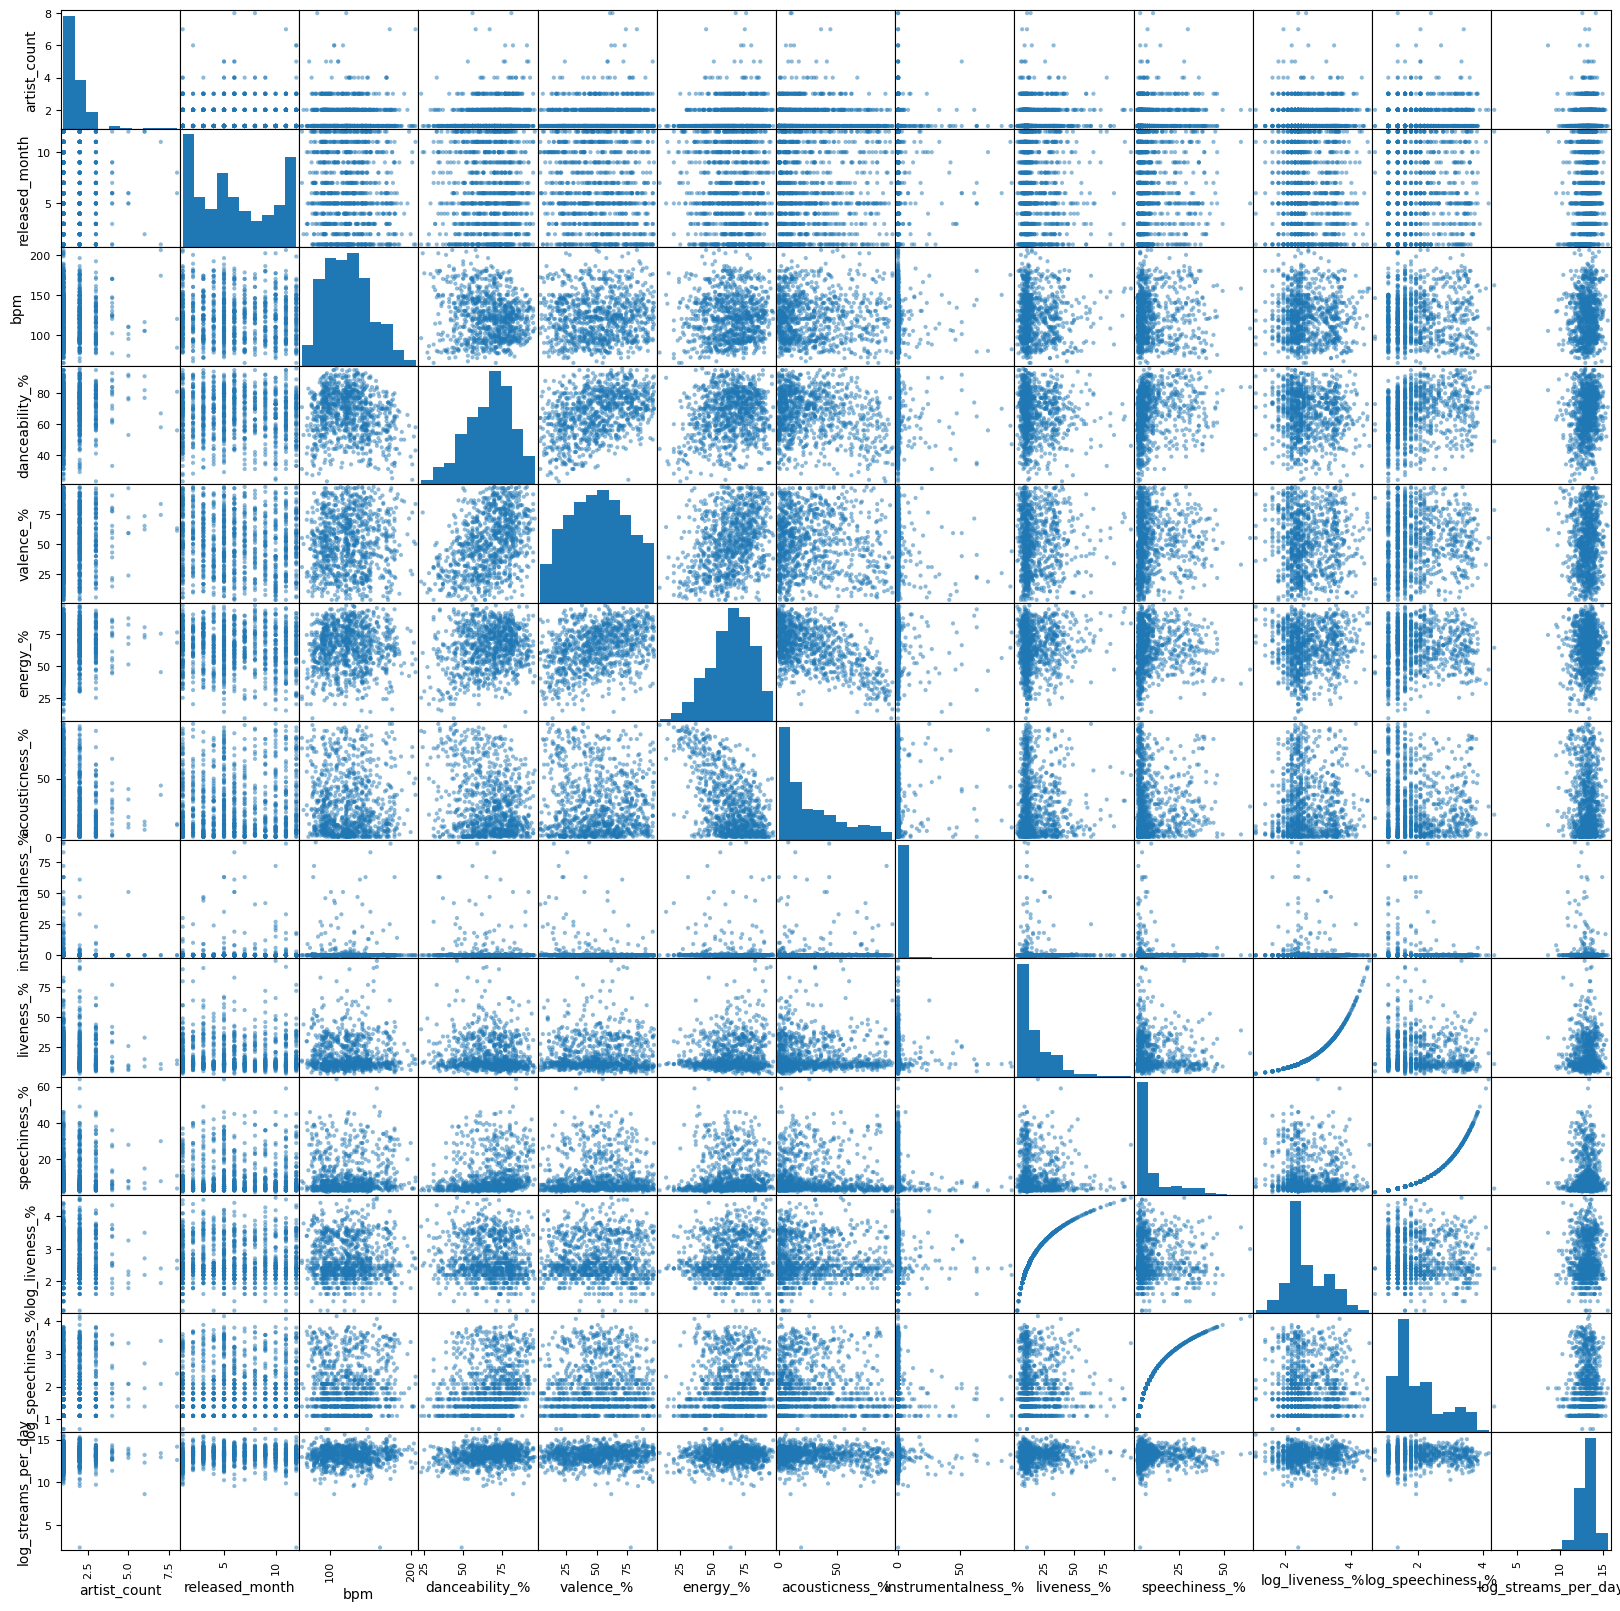

In [13]:
# Scatter plots and histograms for every numerical value combination
axs = pd.plotting.scatter_matrix(songs.drop(columns='mode_Minor'), figsize=(20,20))

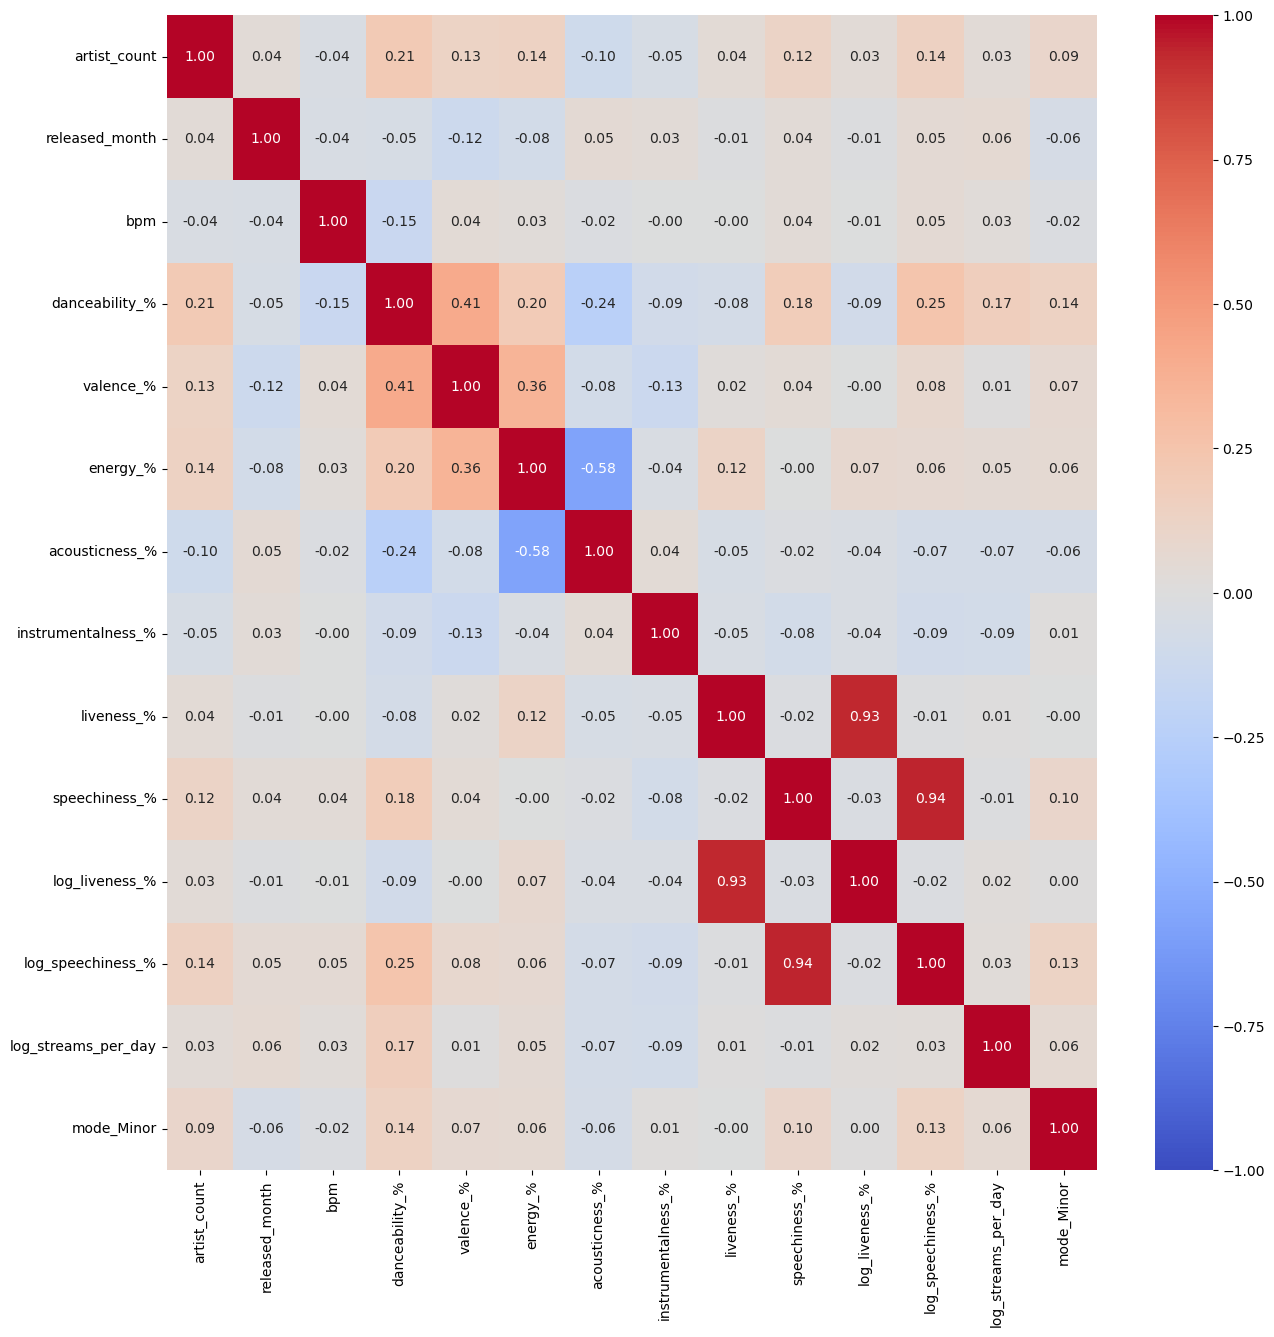

In [14]:
fig, ax = plt.subplots(figsize=(15,15))         
sns.heatmap(
    songs.corr(numeric_only=True),
    cmap ='coolwarm',
    center=0, 
    vmin=-1,
    vmax=1,
    annot=True,
    fmt='.2f' 
    );

# 5. Model Building

## 5.1 Linear Regression Model

In [15]:
# Define X and y variables
X = songs.drop(columns=['log_streams_per_day'])
y = songs.log_streams_per_day

# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

In [16]:
# Instantiate the model
lr = LinearRegression()

# Fit the model
lr.fit(X_train, y_train)

# Instantiate dummy model
null_model = DummyRegressor()

# Fit dummy model
null_model.fit(X_train, y_train)

# Make prediction on test set with dummy model
y_pred_null = null_model.predict(X_test)

# Report MAE score on test data for dummy model
dummy_model_score = metrics.mean_absolute_error(y_test, y_pred_null)
print(f'Dummy model MAE:{dummy_model_score}')

# Make prediction on test set with LR model
y_pred = lr.predict(X_test)

# Report MAE scores for the predictions on testing set
linear_regression_model_score = metrics.mean_absolute_error(y_test, y_pred)
print(f'Linear Regression Model MAE: {linear_regression_model_score}')

Dummy model MAE:0.764708881270891
Linear Regression Model MAE: 0.7519073960067294


In [17]:
# Instantiate Grid Search Cross Validation with KFold
grid = GridSearchCV(
    estimator=LinearRegression(),
    param_grid={},
    cv=KFold(10, shuffle = True),
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)

# Fit the data
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=LinearRegression(), n_jobs=-1, param_grid={},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [18]:
# Find best MAE score
pd.DataFrame(grid.cv_results_)[[
    'mean_train_score',
    'mean_test_score',]].sort_values('mean_test_score', ascending=False).head(1)

,mean_train_score,mean_test_score
0,-0.682869,-0.692053


In [19]:
tuned_linear_regression_model_score = grid.best_score_

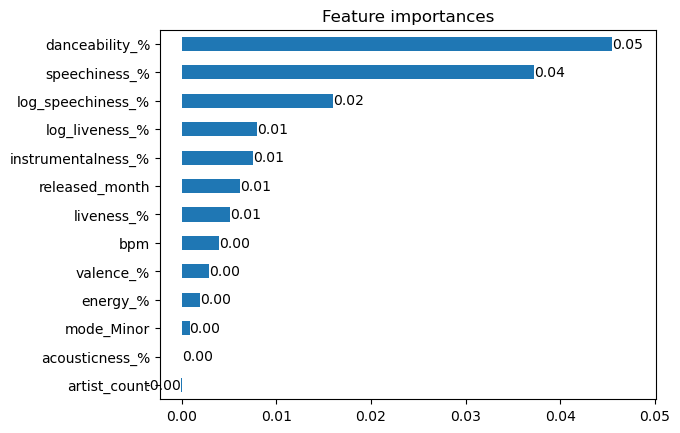

In [20]:
# Identify which features are most important
inspector = get_inspector(grid, X, y)
inspector.plot_permutation_importance();

## 5.2 Decision Tree Model

Decision Treel Model MAE: 1.0774223922743331


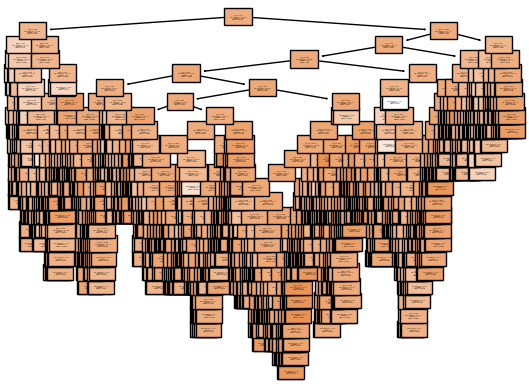

In [21]:
# Instantiate the model
dtr = DecisionTreeRegressor()

# Fit the model
dtr.fit(X_train, y_train)

# Create prediction on test data
y_pred = dtr.predict(X_test)

decision_tree_model_score = metrics.mean_absolute_error(y_test, y_pred)

# Report MAE scores for the predictions on testing set
print(f'Decision Treel Model MAE: {decision_tree_model_score}')

# Plot the decision tree
plot_tree(dtr, filled=True, fontsize=0);

In [22]:
# Instantiate Grid Search Cross Validation with KFold on Decision Tree
grid = GridSearchCV(
    estimator=DecisionTreeRegressor(),
#     Tune parameters
    param_grid={'min_samples_leaf':[1,2,3,5,10]},
    cv=KFold(10, shuffle = True),
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)

# Fit the data
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 3, 5, 10]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [23]:
# Find best MAE score and associated parameters
pd.DataFrame(grid.cv_results_)[[
    'mean_train_score',
    'mean_test_score',
    'param_min_samples_leaf']].sort_values('mean_test_score', ascending=False).head(1)


,mean_train_score,mean_test_score,param_min_samples_leaf
4,-0.551678,-0.781931,10


In [24]:
tuned_decision_tree_model_score = grid.best_score_

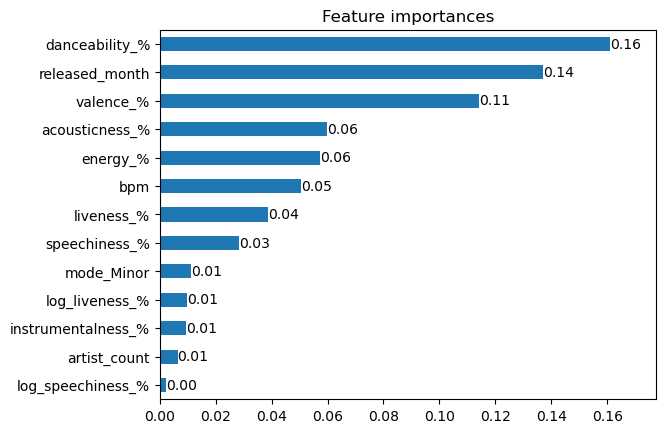

In [25]:
# Identify which features are most important
inspector = get_inspector(grid, X, y)
inspector.plot_permutation_importance();

## 5.3 Random Forest Model

In [26]:
# Instantiate the model
rfr = RandomForestRegressor()

# Fit the model
rfr.fit(X_train, y_train)

# Create prediction on test data
y_pred = rfr.predict(X_test)

random_forest_model_score = metrics.mean_absolute_error(y_test, y_pred)
# Report MAE scores for the predictions on testing set
print(f'Random Forest Model Testing MAE: {random_forest_model_score}')

Random Forest Model Testing MAE: 0.736788005837539


In [27]:
# Instantiate Grid Search Cross Validation with KFold on Random Forest
max_feature_vals = [
    1.0,
    0.5,
    np.sqrt(len(X.columns))/len(X.columns),
    1/3
]
grid = GridSearchCV(
    estimator=RandomForestRegressor(),
#     Tune parameters
    param_grid={'n_estimators': range(10, 600, 50), 
                'max_features':max_feature_vals, 
                'min_samples_leaf':[1,3,5,7,10]},
    cv=KFold(10, shuffle = True),
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)
# Fit the data
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': [1.0, 0.5, 0.2773500981126146,
                                          0.3333333333333333],
                         'min_samples_leaf': [1, 3, 5, 7, 10],
                         'n_estimators': range(10, 600, 50)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [28]:
# Find best MAE score and associated parameters
pd.DataFrame(grid.cv_results_)[[
    'mean_train_score',
    'mean_test_score',
    'param_max_features',
    'param_min_samples_leaf', 'param_n_estimators']].sort_values('mean_test_score', ascending=False).head(1)

,mean_train_score,mean_test_score,param_max_features,param_min_samples_leaf,param_n_estimators
196,-0.397279,-0.654385,0.333333,3,210


In [29]:
tuned_random_forest_model_score = grid.best_score_

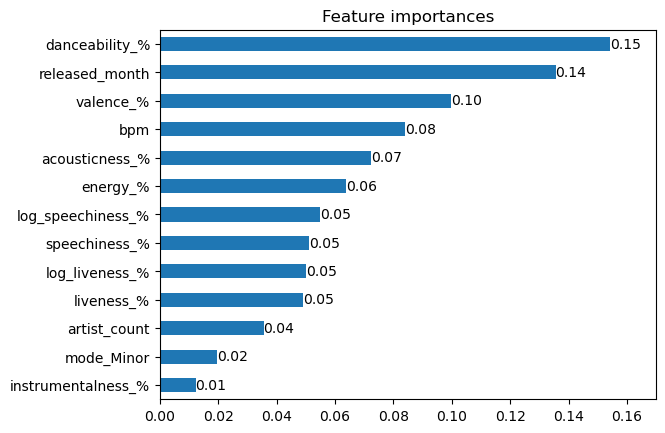

In [30]:
# Identify which features are most important
inspector = get_inspector(grid, X, y)
inspector.plot_permutation_importance();

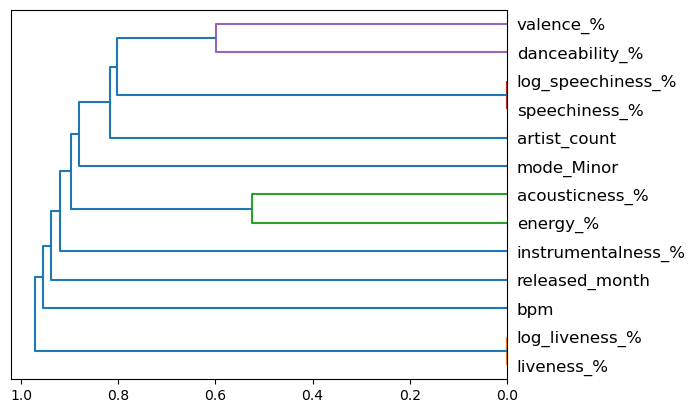

In [31]:
ax = inspector.plot_feature_clusters()

# 6. Model Evaluation

It seems that the tuned Random Forest Model is the best choice. Both versions of the Linear Regression and Random Forest models performed better than the dummy model. Given the size of the target variable, this score doesn't seem too bad, but would ideally be much smaller. I think a better way to test the model would be to input data from a selection of songs of varying popularity to see if there is signal in the data to show any correlations between popular songs vs non-popular songs.

In [32]:
model_type = ['Dummy',
              'Linear Regression',
              'Tuned Linear Regression',
              'Decision Tree', 
              'Tuned Decision Tree',
              'Random Forest',
              'Tuned Random Forest']
test_results = [dummy_model_score, 
                linear_regression_model_score, 
                np.abs(tuned_linear_regression_model_score), 
                decision_tree_model_score,
                np.abs(tuned_decision_tree_model_score),
                random_forest_model_score,
                np.abs(tuned_random_forest_model_score)
               ]
model_test_results = pd.DataFrame({'model_type':model_type, 'test_results':test_results})
model_test_results.sort_values('test_results', ascending=True)

,model_type,test_results
6,Tuned Random Forest,0.654385
2,Tuned Linear Regression,0.692053
5,Random Forest,0.736788
1,Linear Regression,0.751907
0,Dummy,0.764709
4,Tuned Decision Tree,0.781931
3,Decision Tree,1.077422
